In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import os
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Cell 2: Load Data
#data = pd.read_parquet("data/gdsc_single_cell_aligned.parquet")
data = pd.read_parquet("data/top20_drugs_dataset.parquet")

gene_emb = pd.read_parquet("data/gene_embeddings.parquet")

# If "gene" is a column instead of index, fix it
if "gene" in gene_emb.columns:
    gene_emb.set_index("gene", inplace=True)

print("Expression data shape:", data.shape)
print("Gene embedding matrix shape:", gene_emb.shape)


Expression data shape: (37365, 2003)
Gene embedding matrix shape: (37307, 512)


In [3]:
# Cell 3: Train per-drug models with gene embeddings
os.makedirs("models_xgb", exist_ok=True)

gene_cols = [col for col in data.columns if col not in ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]]
embed_dim = gene_emb.shape[1]
all_results = []
i = 0

for drug_id in sorted(data["DRUG_ID"].unique()):
    if i >= 20:
        break
    i += 1
    print(f"\n🔬 Drug ID: {drug_id}")
    
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    
    if df.shape[0] < 10:
        print("❗ Skipped (not enough samples)")
        continue
    
    # Expression matrix
    X_expr = df[gene_cols]
    y = df["LN_IC50"].values
    
    # Filter HVGs that exist in the embedding file
    valid_genes = [g for g in gene_cols if g in gene_emb.index]
    if len(valid_genes) == 0:
        print("⚠️ No valid genes with embeddings found.")
        continue
    
    expr_matrix = X_expr[valid_genes].values
    emb_matrix = gene_emb.loc[valid_genes].values  # (genes, 512)
    
    # Weighted avg of gene embeddings
    emb_features = expr_matrix @ emb_matrix  # (samples, 512)

    # Final input = expression + embedding
    X_final = np.hstack([expr_matrix, emb_features])
    
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )
    
    # Train XGBoost
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Eval
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    print(f"✅ RMSE: {rmse:.4f} | R²: {r2:.4f}")
    
    # Save
    path = f"models_xgb/xgb_drug_{drug_id}.pkl"
    joblib.dump(model, path)
    
    all_results.append({
        "DRUG_ID": drug_id,
        "num_samples": len(df),
        "rmse": rmse,
        "r2": r2,
        "model_path": path
    })



🔬 Drug ID: 1007
✅ RMSE: 1.6054 | R²: -0.0031

🔬 Drug ID: 1010
✅ RMSE: 2.2864 | R²: -1.0820

🔬 Drug ID: 1011
✅ RMSE: 1.5564 | R²: 0.3147

🔬 Drug ID: 1017
✅ RMSE: 1.3267 | R²: -0.1650

🔬 Drug ID: 1022
✅ RMSE: 1.3967 | R²: 0.2289

🔬 Drug ID: 1032
✅ RMSE: 1.3444 | R²: 0.1028

🔬 Drug ID: 1036
✅ RMSE: 1.2405 | R²: 0.2481

🔬 Drug ID: 1046
✅ RMSE: 1.3693 | R²: -0.0918

🔬 Drug ID: 1047
✅ RMSE: 1.6038 | R²: 0.0957

🔬 Drug ID: 1053
✅ RMSE: 1.7041 | R²: -0.1968

🔬 Drug ID: 1054
✅ RMSE: 2.2819 | R²: -0.6354

🔬 Drug ID: 1057
✅ RMSE: 1.7234 | R²: -0.2672

🔬 Drug ID: 1060
✅ RMSE: 2.5416 | R²: -0.2225

🔬 Drug ID: 1091
✅ RMSE: 1.1640 | R²: 0.2026

🔬 Drug ID: 1199
✅ RMSE: 1.0882 | R²: -0.2353

🔬 Drug ID: 1239
✅ RMSE: 1.7577 | R²: -0.2503

🔬 Drug ID: 1259
✅ RMSE: 1.9352 | R²: 0.0467

🔬 Drug ID: 1372
✅ RMSE: 2.1236 | R²: 0.3367

🔬 Drug ID: 1375
✅ RMSE: 1.2414 | R²: -0.1474

🔬 Drug ID: 1494
✅ RMSE: 1.5068 | R²: 0.2817


In [4]:
# Cell 4: Save performance summary
results_df = pd.DataFrame(all_results)
results_df.to_csv("models_xgb/model_performance_summary.csv", index=False)
results_df.head()

,DRUG_ID,num_samples,rmse,r2,model_path
0,1007,1900,1.605373,-0.003141,models_xgb/xgb_drug_1007.pkl
1,1010,1885,2.286397,-1.081988,models_xgb/xgb_drug_1010.pkl
2,1011,1895,1.556427,0.314664,models_xgb/xgb_drug_1011.pkl
3,1017,1899,1.326731,-0.165027,models_xgb/xgb_drug_1017.pkl
4,1022,1892,1.396685,0.228878,models_xgb/xgb_drug_1022.pkl


/tmp/ipykernel_4064768/2122229205.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(results_df["DRUG_ID"].astype(str), rotation=45)


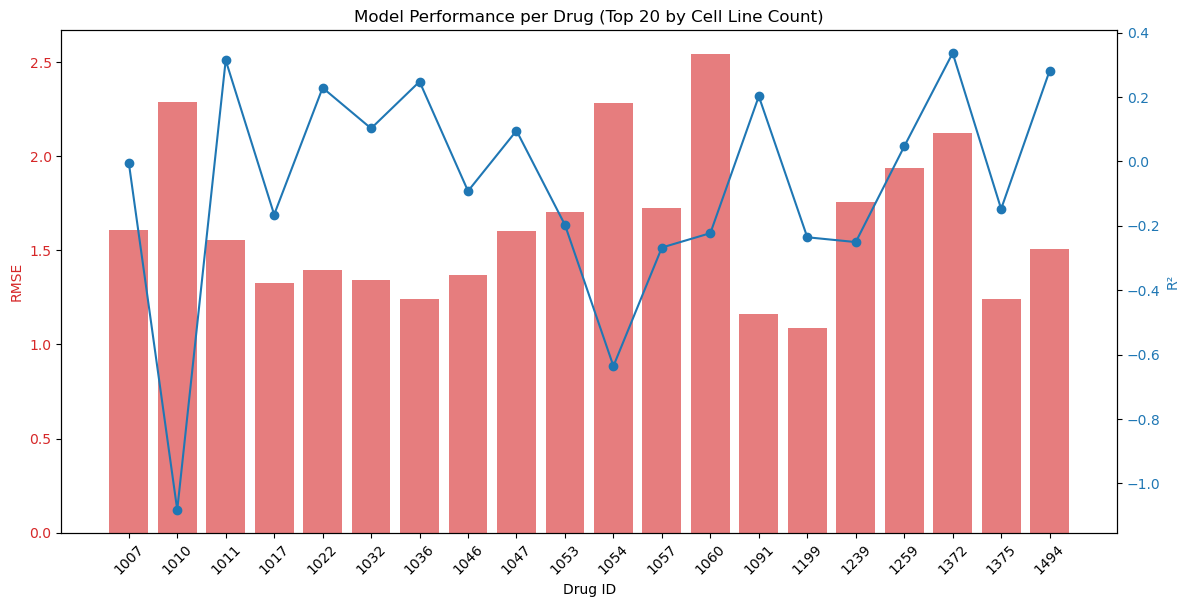

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Drug ID')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(results_df["DRUG_ID"].astype(str), results_df["rmse"], color=color, alpha=0.6, label="RMSE")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(results_df["DRUG_ID"].astype(str), rotation=45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('R²', color=color)
ax2.plot(results_df["DRUG_ID"].astype(str), results_df["r2"], color=color, marker="o", label="R²")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Model Performance per Drug (Top 20 by Cell Line Count)")
plt.show()
